# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [10]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]


## Data Loading and Preprocessing



In [11]:
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint
import os


# To make random outcomes reproducible
SEED = 1738
BATCH_SIZE = 128
IMAGE_SIZE = 128
TRAIN_DIRECTORY = Path("./train")


train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="categorical",
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True
)

class_count = {}

for image, label in train_ds:
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

minimum_class = min(class_count, key=class_count.get)  # type: ignore
minimum_class_count = min(class_count.values())

# pprint(class_count)
# print(f"MINIMUM: {minimum_class}, {minimum_class_count} ")

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


In [12]:
class_datasets = []
for class_idx in range(len(classes)):
    class_ds: tf.data.Dataset = train_ds.filter(lambda img, label: tf.argmax(label) == class_idx)
    class_datasets.append(class_ds.take(minimum_class_count).shuffle(buffer_size=minimum_class_count, seed=SEED))


# Recombine the class datasets using sample_from_datasets to interweave them
train_ds_balanced = tf.data.Dataset.sample_from_datasets(
    class_datasets, seed=SEED
)

class_count = {}
for image, label in train_ds_balanced:  # type: ignore
    key = str(label.numpy())
    if class_count.get(key) == None:
        class_count[key] = 1
    else:
        class_count[key] += 1

pprint(class_count)

# Repeat to ensure model won't run out of data
# Batch the data set for model compatibility
# Prefetch to optimize

def config_performance(dataset):
    dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset.prefetch(tf.data.AUTOTUNE)

train_ds_optimized = config_performance(train_ds_balanced)
validation_ds_optimized = config_performance(validation_ds)

{'[0. 0. 0. 0. 0. 1.]': 228,
 '[0. 0. 0. 0. 1. 0.]': 228,
 '[0. 0. 0. 1. 0. 0.]': 228,
 '[0. 0. 1. 0. 0. 0.]': 228,
 '[0. 1. 0. 0. 0. 0.]': 228,
 '[1. 0. 0. 0. 0. 0.]': 228}


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [20]:
import keras
from keras.api.applications.inception_v3 import InceptionV3

EPOCHS = 5
DROPOUT_RATE = 0.2

pre_trained_model = InceptionV3(
    weights="imagenet",
    classes=len(classes),
    include_top=False,  # the fully connected layer at the end
)

for layer in pre_trained_model.layers:
    layer.trainable = False

transfer_model = keras.models.Sequential([
    # preprocessing layers
    keras.layers.Rescaling(1./255),
    # data augmentation layers
    keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    keras.layers.RandomRotation(0.05, seed=SEED),
    pre_trained_model,
    # fully connected
    # keras.layers.Flatten(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(DROPOUT_RATE),
    keras.layers.Dense(len(classes), activation="softmax"),
])

# transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = transfer_model.fit(
    train_ds_optimized, epochs=EPOCHS, validation_data=validation_ds_optimized
)

Epoch 1/5
     11/Unknown 11s 541ms/step - accuracy: 0.2697 - loss: 5.8180

/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2728 - loss: 5.7810 - val_accuracy: 0.5186 - val_loss: 1.3645
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4310 - loss: 1.5720 - val_accuracy: 0.5476 - val_loss: 1.2097
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 927ms/step - accuracy: 0.5366 - loss: 1.1872 - val_accuracy: 0.5580 - val_loss: 1.1057
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6075 - loss: 1.0454

2025-05-16 17:14:51.182671: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6076 - loss: 1.0460 - val_accuracy: 0.5766 - val_loss: 1.0631
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6166 - loss: 0.9979 - val_accuracy: 0.6021 - val_loss: 1.0951


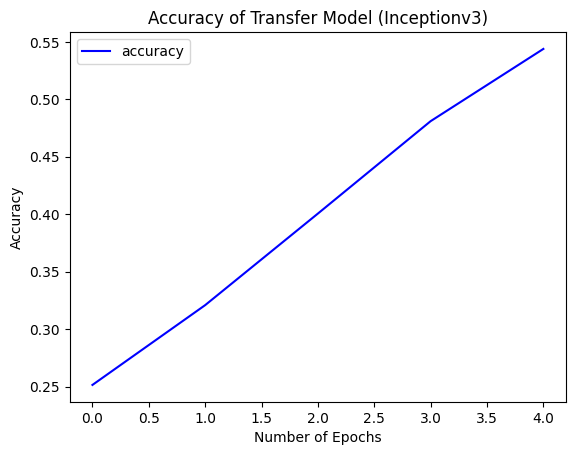

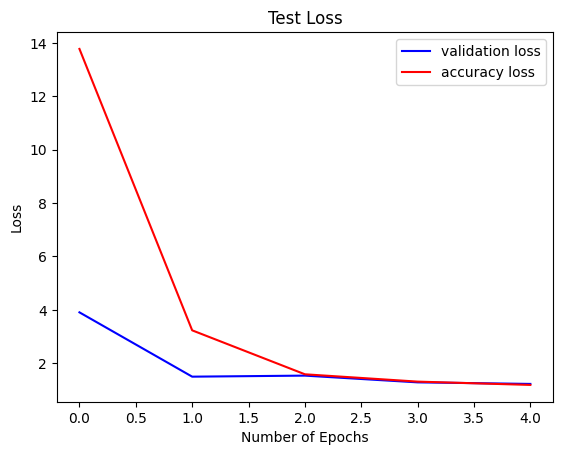

In [15]:
import matplotlib.pyplot as plt

# show the accuracy of method 2
plt.plot(history.history["accuracy"], color="b", label="accuracy")
plt.title("Accuracy of Transfer Model (Inceptionv3)")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# show the training (and validation) loss of method 2
plt.plot(history.history["val_loss"], color="b", label="validation loss")
plt.plot(history.history["loss"], color="r", label="accuracy loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,396,468 (131.21 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 8,395,790 (32.03 MB)